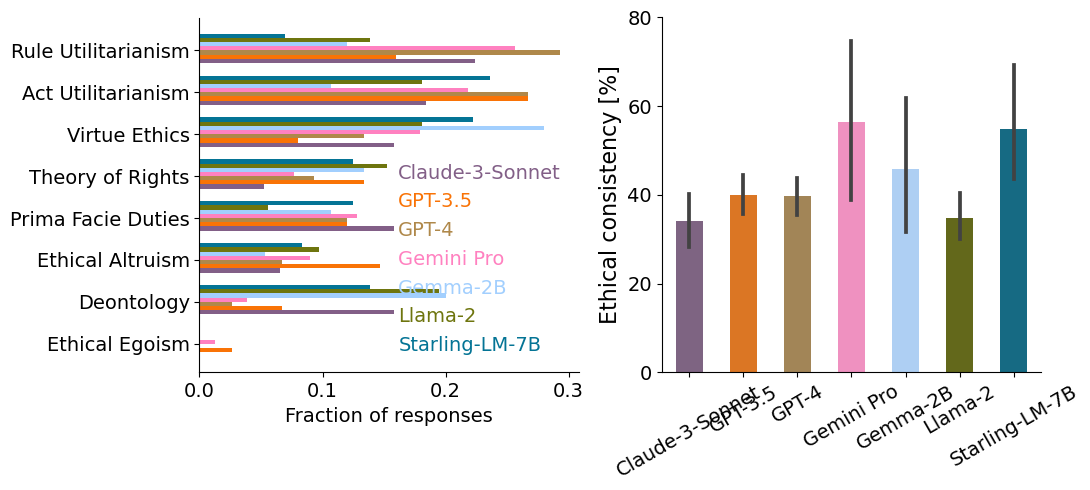

In [625]:
import pandas as pd
from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt
from natsort import natsorted
import seaborn as sns
color_names = ["dusty purple", "orange", "dark tan", "pink", "baby blue", "olive", "sea blue", "dusty red", "faded green", "amber", "windows blue"]
colors = sns.xkcd_palette(color_names)

def process_csv_data(file_path, all_categories):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_path, header=None)
    df.columns = [f'iter{i+1}' for i in range(len(df.columns))]  # Rename columns for iteration

    # Initialize a dictionary to count occurrences of each category
    category_counts = dict.fromkeys(all_categories, 0)

    # Flatten the DataFrame and count each occurrence of categories
    for category in all_categories:
        if category == 'Principio Único del Deber':
            category_counts['Deontología Clásica'] = (df.values == category).sum()
        else:
            category_counts[category] = (df.values == category).sum()

    # Calculate the percentage for each category
    total_counts = sum(category_counts.values())
    category_percentages = {category: (count / total_counts) if total_counts else 0 for category, count in category_counts.items()}

    return category_percentages

def collect_all_percentages(directory_path, all_categories):
    all_percentages = []

    # Iterate through each CSV file and process the data
    for file_path in natsorted(glob(os.path.join(directory_path))):
        percentages = process_csv_data(file_path, all_categories)
        all_percentages.append(percentages)

    return all_percentages

def calculate_consistency(directory_path, labels):
    # Get a list of all CSV files in the directory
    csv_files = glob(os.path.join(directory_path))
    
    # A dictionary to hold the number of unique responses for each question for each file
    unique_answers_per_question = {labels[ii]: [] for ii in range(len(labels))}
    
    # Iterate over the files
    for ii, file_path in enumerate(csv_files):
        df = pd.read_csv(file_path, header=None)
        # Replace empty cells with NaN
        df.replace('', np.nan, inplace=True)
        
        # Split the DataFrame by rows with NaN values indicating a new question
        question_indices = df[df.isna().all(axis=1)].index
        start_idx = 0
        for end_idx in question_indices:
            # Slice the DataFrame to separate each question's data
            question_df = df.iloc[start_idx:end_idx].dropna(axis=1, how='all')
            unique_count = question_df.apply(lambda x: x.nunique(), axis=1)
            unique_answers_per_question[labels[ii]].append(np.nanmean(unique_count))
            start_idx = end_idx + 1
        
        # Handle the last question block
        if start_idx < len(df):
            question_df = df.iloc[start_idx:].dropna(axis=1, how='all')
            unique_count = question_df.apply(lambda x: x.nunique(), axis=1)
            unique_answers_per_question[labels[ii]].append(np.nanmean(unique_count))
    
    # Invert the standard deviations
    means_per_question = {k: [s if s != 0 else 0 for s in v] for k, v in unique_answers_per_question.items()}
    
    # Determine the maximum number of questions across all files
    max_num_questions = max(len(v) for v in unique_answers_per_question.values())
    
    # Prepare the data for plotting
    plot_data = {k: v + [np.nan]*(max_num_questions-len(v)) for k, v in means_per_question.items()}
    plot_df = pd.DataFrame(plot_data)

    return plot_df

def plot_bars(all_percentages, colors, labels, ax):
    """
    Plots an overlayed radar chart of classification percentages for multiple subjects.
    
    :param all_percentages: List of dictionaries with classification percentages for each subject.
    :param category_labels: List of strings containing the category labels.
    :param title: The title for the radar chart.
    :param colors: List of colors for each subject's plot.
    """
    # Number of variables (categories) we're plotting.
    category_labels2 = ['Rule Utilitarianism', 'Act Utilitarianism', 'Virtue Ethics', 'Theory of Rights', 
    'Prima Facie Duties', 'Ethical Altruism', 'Deontology', 'Ethical Egoism']
    num_vars = len(category_labels2)
    
    # Compute angle for each axis.
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # Complete the loop.

    #fig, ax = plt.subplots(figsize=(6, 6))#, subplot_kw=dict(polar=True))

    # Draw one axe per variable and add labels.
    #ax.set_thetagrids(np.degrees(angles[:-1]), category_labels2)
    
    # Plot data and fill area for each subject.
    for idx, subject_percentages in enumerate(all_percentages):

        idx_cat = np.array(all_categories)!='Principio Único del Deber'    
        values = np.array(list(subject_percentages.values()))# + [list(subject_percentages.values())[0]]
        values = values[idx_cat].copy()
        ax.barh(y = np.arange(len(category_labels2))+0.1*idx, width = values[::-1], color=colors[idx], height=0.1, label=labels[idx])
        #ax.fill(angles, values, color=colors[idx], alpha=0.1)
    ax.set_yticks(np.arange(len(category_labels2))+0.25, category_labels2[::-1], fontsize = 14)
    ax.set_xticks(np.linspace(0, 0.3, 4), np.linspace(0, 0.3, 4).round(1), fontsize = 14)
    ax.set_xlabel('Fraction of responses', fontsize = 14)
    ax.legend(loc = 'lower right', frameon = False, handlelength = 0, labelcolor = 'linecolor', fontsize = 14)
    #plt.grid(visible=False)
    return

# List of all possible categories
all_categories = [
    'Utilitarismo de Norma', 'Utilitarismo de Acto', 'Ética de la Virtud Clásica', 'Teoría de los Derechos', 
    'Deberes Prima Facie (Aparentes)', 'Altruismo Ético', 'Deontología Clásica', 'Egoísmo Ético'
]

# Directory containing the CSV files
directory_path = 'Dilemmas_Results/Dilemas*.csv'
#directory_path = 'Dilemmas_Results/Dilemmas - Ethical School Classification - Steered Gemini-2B.csv'

labels = ['Claude-3-Sonnet', 'GPT-3.5', 'GPT-4', 'Gemini Pro', 'Gemma-2B', 'Llama-2', 'Starling-LM-7B']

# Collect all percentages
all_percentages = collect_all_percentages(directory_path, all_categories)


fig, ax = plt.subplots(figsize=(11, 5), ncols = 2)
# Plot the radar chart with all subjects' data overlaid
plot_bars(all_percentages, colors, labels, ax[0])

# Call the function
plot_df = calculate_consistency(directory_path, labels)
sns.barplot(data = 1/plot_df, palette = colors, width = 0.5, errorbar=('ci', 90), ax = ax[1])

ax[1].set_ylabel('Ethical consistency [%]', fontsize = 16)
ax[1].set_xticks(np.arange(len(labels)), labels, fontsize = 14, rotation = 30)
ax[1].set_ylim(0, 0.8)
ax[1].set_yticks(np.linspace(0, 0.8, 5), np.linspace(0, 80, 5).astype(int), fontsize = 14)
sns.despine()
plt.tight_layout()
#ax.set_rlim([-0.01, 0.3])
#ax.set_rticks(np.linspace(0, 0.3, 4), np.linspace(0, 0.3, 4).round(1), fontsize = 10)

#plt.savefig('Dilemmas_Results_Eng_13042024.svg', transparent = True)

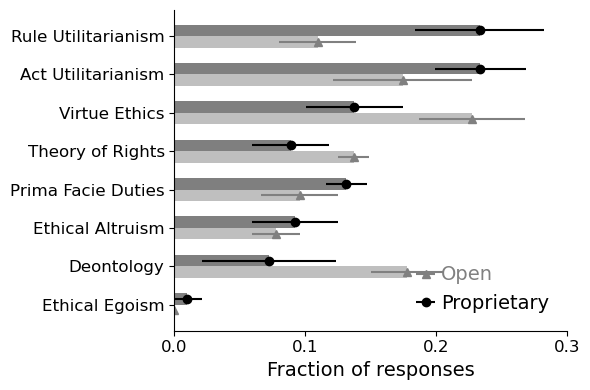

In [626]:
import numpy as np

def aggregate_values(dictionaries, specific_keys=None):
    # Initialize a dictionary to store lists of values for each key
    value_lists = {}
    
    # Iterate through each dictionary
    for dictionary in dictionaries:
        for key, value in dictionary.items():
            # If specific_keys is defined, skip keys not in specific_keys
            if specific_keys is not None and key not in specific_keys:
                continue
            
            # Collect values for each key
            if key in value_lists:
                value_lists[key].append(value)
            else:
                value_lists[key] = [value]
    
    # Initialize a dictionary to store the mean and std for each key
    aggregated_results = {}
    for key, values in value_lists.items():
        # Calculate mean and std
        mean_value = np.mean(values)
        std_value = np.std(values)
        
        # Store the mean and std in the results dictionary
        aggregated_results[key] = {'mean': mean_value, 'std': std_value}
    
    return aggregated_results

pooled_proprietary = aggregate_values(all_percentages[:4])
pooled_open = aggregate_values(all_percentages[4:])
# Extracting means and stds
proprietary_means = [pooled_proprietary[cat]['mean'] for cat in all_categories[::-1]]
proprietary_stds = [pooled_proprietary[cat]['std'] for cat in all_categories[::-1]]
open_means = [pooled_open[cat]['mean'] for cat in all_categories[::-1]]
open_stds = [pooled_open[cat]['std'] for cat in all_categories[::-1]]
category_labels2 = ['Rule Utilitarianism', 'Act Utilitarianism', 'Virtue Ethics', 'Theory of Rights', 
    'Prima Facie Duties', 'Ethical Altruism', 'Deontology', 'Ethical Egoism']

# Plotting
fig, ax = plt.subplots(ncols=1, figsize=(6, 4))
ax.barh(np.arange(len(all_categories)), open_means, height=0.3, color = 'grey', alpha = 0.5)
ax.barh(np.arange(len(all_categories)) + 0.3, proprietary_means, height=0.3, color = 'black', alpha = 0.5)
ax.errorbar(open_means, np.arange(len(all_categories)), xerr=open_stds, fmt='^', color = 'grey', label='Open')
ax.errorbar(proprietary_means, np.arange(len(all_categories)) + 0.3, xerr=proprietary_stds, fmt='o', color='black', label='Proprietary')
ax.set_yticks(np.arange(len(all_categories)) + 0.15, category_labels2[::-1], fontsize = 12)
ax.set_xlim([0, 0.3])
ax.legend(handlelength = 0, labelcolor = 'linecolor', frameon = False, fontsize = 14)
plt.xticks(np.linspace(0, 0.3, 4), np.linspace(0, 0.3, 4).round(1), fontsize = 12)
plt.xlabel('Fraction of responses', fontsize = 14)
sns.despine()
plt.tight_layout()
#plt.savefig('EthicalSchools_OpenVsProprietary_13042024.svg', transparent = True)

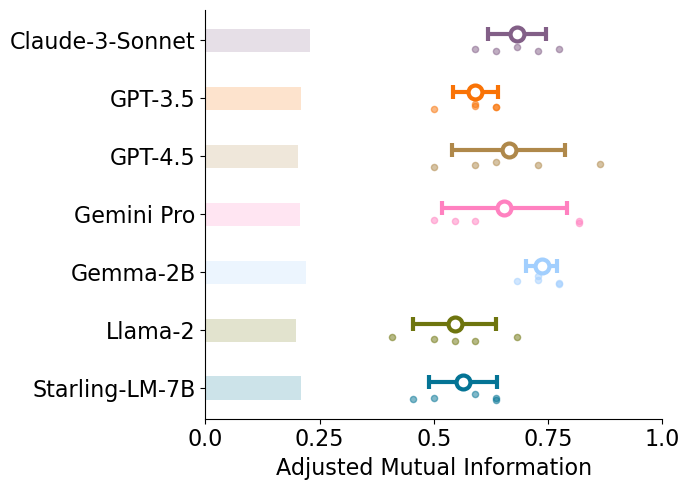

In [634]:
import pandas as pd
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.patches import Rectangle

mods = np.array(['Claude-3-Sonnet', 'GPT-3.5', 'GPT-4.5', 'Gemini Pro', 'Gemma-2B', 'Llama-2', 'Starling-LM-7B'])[::-1]
colors2 = np.concatenate([colors[::-1][4:7], colors[::-1][-4:]])

nmis_all = np.full((len(mods), 5), np.nan)
numShuff = 100
nmis_all_Sh = np.full((len(mods), 5), np.nan)
nmis_all_low_Sh = np.full((len(mods), 5), np.nan)
fig, ax = plt.subplots(figsize = (7,5))

for ii in range(len(mods)):
    df1 = pd.read_csv('Dilemmas_Results/Opus/Dilemas - Clasificación Escuelas Éticas - Opus - '+mods[ii]+'.csv')
    df2 = pd.read_csv('Dilemmas_Results/Dilemas - Clasificación Escuelas Éticas - '+mods[ii]+'.csv')

    dfs = [df1, df2]
    # Encode text labels into integers
    label_encoders = {iter_col: LabelEncoder() for iter_col in df1.columns}

    for iter_col in df1.columns:
        # Concatenate all categories for this iteration across all DataFrames
        all_labels = pd.concat([df[iter_col] for df in dfs], ignore_index=True)
        label_encoders[iter_col].fit(all_labels)

    # Function to calculate NMI for each iteration
    def calculate_nmi(dfs, iter_col):
        encoded_scores = [label_encoders[iter_col].transform(df[iter_col]) for df in dfs]
        nmis = []
        nmis_Sh = []
        nmis_low_Sh = []
        for i in range(len(encoded_scores)):
            for j in range(i+1, len(encoded_scores)):
                nmi = metrics.accuracy_score(encoded_scores[i], encoded_scores[j])
                nmi_Sh = np.full(numShuff, np.nan)
                for s in range(numShuff):
                    nmi_Sh[s] = metrics.adjusted_mutual_info_score(encoded_scores[i], np.random.permutation(encoded_scores[j]))
                nmis.append(nmi)
                nmis_Sh.append(np.nanpercentile(nmi_Sh, 99))
                nmis_low_Sh.append(np.nanpercentile(nmi_Sh, 1))
        
        return nmis, nmis_Sh, nmis_low_Sh

    # Calculate and plot the distribution of NMI scores
    nmi_distributions = {}
    nmi_distributions_Sh = {}
    nmi_distributions_low_Sh = {}
    for iter_col in df1.columns:
        nmi_distributions[iter_col], nmi_distributions_Sh[iter_col], nmi_distributions_low_Sh[iter_col] = calculate_nmi(dfs, iter_col)

    # Plotting the distributions
    nmis_all[ii,:] = np.array(list(nmi_distributions.values())).ravel()
    nmis_all_Sh[ii,:] = np.array(list(nmi_distributions_Sh.values())).ravel()
    nmis_all_low_Sh[ii,:] = np.array(list(nmi_distributions_low_Sh.values())).ravel()

    plt.scatter(y = [np.arange(len(mods))[ii]]+np.random.random(size = nmis_all.shape[1])*0.1-np.random.random(size = nmis_all.shape[1])*0.1, 
                    x = nmis_all[ii,:], alpha = 0.5, s = 20, color = colors2[ii])
    plt.errorbar(y = [ii+0.25], x = np.nanmean(nmis_all[ii,:], axis = 0), xerr=np.nanstd(nmis_all[ii,:], axis = 0), ls = '', marker = 'o', color = colors2[ii], ms = 10,
                 elinewidth=3, capsize=5, capthick=3, mfc = 'white', mew = 3)
    xmin = np.nanmean(nmis_all_low_Sh[ii,:])
    xmax = np.nanmean(nmis_all_Sh[ii,:])
    width = xmax - xmin
    height = 0.4

    # Create a Rectangle patch
    rect = Rectangle((xmin, ii - 0.05), width, height, linewidth=2, edgecolor=colors2[ii], facecolor=colors2[ii], alpha = 0.2, ls='')

    # Add the rectangle to the current axes
    plt.gca().add_patch(rect)
plt.yticks(np.arange(len(mods))+0.15, mods, fontsize = 16)
plt.xlabel('Adjusted Mutual Information', fontsize = 16)
plt.xticks(np.linspace(0, 1, 5), np.linspace(0, 1, 5), fontsize = 16)
plt.xlim(0,1)
plt.tight_layout()
sns.despine()
#plt.savefig('Inter-Scorer-Agreement_16042024.svg', transparent = True)

In [633]:
np.concatenate([colors[::-1][4:7], colors[::-1][-4:]])

array([[0.01568627, 0.45490196, 0.58431373],
       [0.43137255, 0.45882353, 0.05490196],
       [0.63529412, 0.81176471, 0.99607843],
       [1.        , 0.50588235, 0.75294118],
       [0.68627451, 0.53333333, 0.29019608],
       [0.97647059, 0.45098039, 0.02352941],
       [0.50980392, 0.37254902, 0.52941176]])

In [631]:
np.array(colors[::-1][4:7])

array([[0.01568627, 0.45490196, 0.58431373],
       [0.43137255, 0.45882353, 0.05490196],
       [0.63529412, 0.81176471, 0.99607843]])

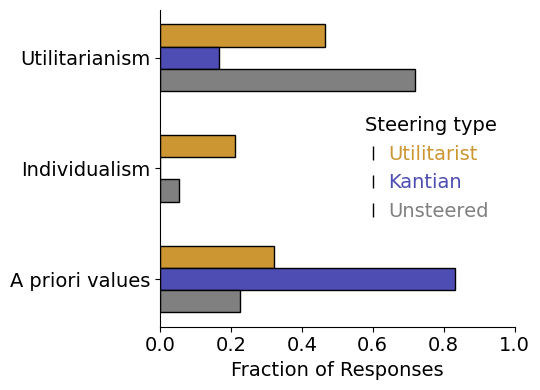

In [624]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample dataframe similar to your structure
dat_steer = pd.read_csv('Dilemmas_Results/Dilemmas - Ethical School Classification - Steered Gemini-2B.csv', sep=';')

# Add Layer column
layer_col = []
layer_count = 0

for i, row in dat_steer.iterrows():
    if row['Utilitarist'] == 'Nan' and row['Kantian'] == 'Nan':
        layer_count += 1
    layer_col.append(layer_count)

dat_steer['Layer'] = layer_col

# Melt the dataframe for easier plotting
df_melted = dat_steer.melt(id_vars=['Layer'], value_vars=['Utilitarist', 'Kantian'], var_name='Category', value_name='Response')

# Remove rows where Response is NaN or '-'
df_melted = df_melted[~df_melted['Response'].isin(['Nan', pd.NA])]

# Aggregate responses over all layers for each category and compute fractions
agg_counts = df_melted.groupby(['Category', 'Response']).size().reset_index(name='Counts')
total_counts = agg_counts.groupby('Category')['Counts'].sum().reset_index(name='Total')
agg_counts = agg_counts.merge(total_counts, on='Category')
agg_counts['Fraction'] = agg_counts['Counts'] / agg_counts['Total']

# Ensure all categories are present in each subplot
all_categories_eng = ['Rule Utilitarianism', 'Act Utilitarianism', 'Classical Virtue Ethics', 'Theory of Rights', 
                      'Prima Facie Duties', 'Ethical Altruism', 'Classical Deontology', 'Ethical Egoism']
missing_entries = []
for category in ['Utilitarist', 'Kantian']:
    for response in all_categories_eng:
        if not ((agg_counts['Category'] == category) & (agg_counts['Response'] == response)).any():
            missing_entries.append({'Category': category, 'Response': response, 'Counts': 0, 'Total': total_counts[total_counts['Category'] == category]['Total'].values[0], 'Fraction': 0})

if missing_entries:
    missing_df = pd.DataFrame(missing_entries)
    agg_counts = pd.concat([agg_counts, missing_df], ignore_index=True)

# Calculate the mean and standard deviation of the fractions by layer
layered_fractions = df_melted.groupby(['Layer', 'Category', 'Response']).size().reset_index(name='Counts')
total_layer_counts = layered_fractions.groupby(['Layer', 'Category'])['Counts'].sum().reset_index(name='Total')
layered_fractions = layered_fractions.merge(total_layer_counts, on=['Layer', 'Category'])
layered_fractions['Fraction'] = layered_fractions['Counts'] / layered_fractions['Total']

# Calculate standard deviations
response_sd = layered_fractions.groupby(['Category', 'Response'])['Fraction'].std().reset_index(name='StdDev')

# Merge standard deviations into aggregated counts
agg_counts = agg_counts.merge(response_sd, on=['Category', 'Response'], how='left').fillna(0)

# Convert 'Response' column to categorical with the specified order
agg_counts['Response'] = pd.Categorical(agg_counts['Response'], categories=all_categories_eng, ordered=True)


# Baseline values
unsteered = {
    'Rule Utilitarianism': 0.12,
    'Act Utilitarianism': 0.10666666666666667,
    'Classical Virtue Ethics': 0.28,
    'Theory of Rights': 0.13333333333333333,
    'Prima Facie Duties': 0.10666666666666667,
    'Ethical Altruism': 0.05333333333333334,
    'Classical Deontology': 0.2,
    'Ethical Egoism': 0.0
}
grouped_baseline = {
    'Utilitarianism': unsteered['Rule Utilitarianism'] + unsteered['Act Utilitarianism'],
    'Individualism': unsteered['Ethical Egoism'] + unsteered['Ethical Altruism'],
    'A priori values': unsteered['Classical Virtue Ethics'] + unsteered['Classical Deontology'] + unsteered['Prima Facie Duties'] + unsteered['Theory of Rights']
}
# Group responses into the three main categories
agg_counts['Group'] = agg_counts['Response'].map({
    'Rule Utilitarianism': 'Utilitarianism',
    'Act Utilitarianism': 'Utilitarianism',
    'Ethical Egoism': 'Individualism',
    'Ethical Altruism': 'Individualism',
    'Classical Virtue Ethics': 'A priori values',
    'Classical Deontology': 'A priori values',
    'Prima Facie Duties': 'A priori values',
    'Theory of Rights': 'A priori values',
})

# Remove Ethical Egoism and rows with no group
#agg_counts = agg_counts[~agg_counts['Response'].isin(['Ethical Egoism'])]
agg_counts = agg_counts.dropna(subset=['Group'])

# Sum the fractions for each group
grouped_counts = agg_counts.groupby(['Category', 'Group']).agg({
    'Fraction': 'sum',
    'Counts': 'sum'
}).reset_index()

# Grouped counts to plot
grouped_utilitarianism = grouped_counts[grouped_counts['Group'] == 'Utilitarianism']
grouped_theory_of_rights = grouped_counts[grouped_counts['Group'] == 'Individualism']
grouped_a_priori_values = grouped_counts[grouped_counts['Group'] == 'A priori values']

# Baseline values
baseline_values = {
    'Utilitarianism': grouped_baseline['Utilitarianism'],
    'Individualism': grouped_baseline['Individualism'],
    'A priori values': grouped_baseline['A priori values']
}

# Set up the plot
fig, ax = plt.subplots(figsize=(5.5,4))

# Define the colors
colors = {
    'Baseline': 'gray',
    'Kantian': 'blue',
    'Utilitarist': 'orange'
}

# Define bar heights and offsets
bar_height = 0.4
offset =0.2


ax.barh(y=[2 + (2*offset), 1 + (2*offset), 0 + (2*offset)], width=[
    grouped_utilitarianism[grouped_utilitarianism['Category'] == 'Utilitarist']['Fraction'].values[0],
    grouped_theory_of_rights[grouped_theory_of_rights['Category'] == 'Utilitarist']['Fraction'].values[0],
    grouped_a_priori_values[grouped_a_priori_values['Category'] == 'Utilitarist']['Fraction'].values[0]
], color=sns.desaturate(colors['Utilitarist'], 0.6), height=bar_height / 2, label='Utilitarist', edgecolor='black')

ax.barh(y=[2 + offset, 1 + offset, 0 + offset], width=[
    grouped_utilitarianism[grouped_utilitarianism['Category'] == 'Kantian']['Fraction'].values[0],
    grouped_theory_of_rights[grouped_theory_of_rights['Category'] == 'Kantian']['Fraction'].values[0],
    grouped_a_priori_values[grouped_a_priori_values['Category'] == 'Kantian']['Fraction'].values[0]
], color=sns.desaturate(colors['Kantian'], 0.4), height=bar_height / 2, label='Kantian', edgecolor='black')


# Plot Baseline values
ax.barh(y=['Utilitarianism', 'Individualism', 'A priori values'], width=list(baseline_values.values()), 
        color=sns.desaturate(colors['Baseline'], 0.6), edgecolor='black', height=0.2, label='Unsteered')

# Configure the plot
ax.set_yticks(np.array([0, 1, 2])+0.2)
ax.set_yticklabels(['A priori values', 'Individualism', 'Utilitarianism'], fontsize=14)
ax.set_xlabel('Fraction of Responses', fontsize=14)
ax.set_xlim(0, 1)
ax.set_xticks(np.linspace(0, 1, 6), np.linspace(0, 1, 6).round(1), fontsize=14)
ax.legend(title='Steering type', fontsize=14, title_fontsize=14, frameon = False, handlelength = 0, labelcolor = 'linecolor')
plt.tight_layout()
sns.despine()
plt.savefig('SteeringResults_Aggregated_21052024.svg', transparent = True)

In [622]:
import pandas as pd

# Sample dataframe similar to your structure
dat_steer = pd.read_csv('Dilemmas_Results/Dilemmas - Ethical School Classification - Steered Gemini-2B.csv', sep=';')

# Add Layer column
layer_col = []
layer_count = 0

for i, row in dat_steer.iterrows():
    if row['Utilitarist'] == 'Nan' and row['Kantian'] == 'Nan':
        layer_count += 1
    layer_col.append(layer_count)

dat_steer['Layer'] = layer_col

# Melt the dataframe for easier plotting
df_melted = dat_steer.melt(id_vars=['Layer'], value_vars=['Utilitarist', 'Kantian'], var_name='Category', value_name='Response')

# Remove rows where Response is NaN or '-'
df_melted = df_melted[~df_melted['Response'].isin(['Nan', pd.NA])]

# Aggregate responses within each layer for each category and compute fractions
agg_counts_layer = df_melted.groupby(['Layer', 'Category', 'Response']).size().reset_index(name='Counts')
total_counts_layer = agg_counts_layer.groupby(['Layer', 'Category'])['Counts'].sum().reset_index(name='Total')
agg_counts_layer = agg_counts_layer.merge(total_counts_layer, on=['Layer', 'Category'])
agg_counts_layer['Fraction'] = agg_counts_layer['Counts'] / agg_counts_layer['Total']

# Ensure all categories are present in each subplot
all_categories_eng = ['Rule Utilitarianism', 'Act Utilitarianism', 'Classical Virtue Ethics', 'Theory of Rights', 
                      'Prima Facie Duties', 'Ethical Altruism', 'Classical Deontology', 'Ethical Egoism']
missing_entries_layer = []
for layer in agg_counts_layer['Layer'].unique():
    for category in ['Utilitarist', 'Kantian']:
        for response in all_categories_eng:
            if not ((agg_counts_layer['Layer'] == layer) & (agg_counts_layer['Category'] == category) & (agg_counts_layer['Response'] == response)).any():
                missing_entries_layer.append({'Layer': layer, 'Category': category, 'Response': response, 'Counts': 0, 'Total': total_counts_layer[(total_counts_layer['Layer'] == layer) & (total_counts_layer['Category'] == category)]['Total'].values[0], 'Fraction': 0})

if missing_entries_layer:
    missing_df_layer = pd.DataFrame(missing_entries_layer)
    agg_counts_layer = pd.concat([agg_counts_layer, missing_df_layer], ignore_index=True)

# Add the Group column

agg_counts_layer['Group'] = agg_counts_layer['Response'].map({
    'Rule Utilitarianism': 'Utilitarianism',
    'Act Utilitarianism': 'Utilitarianism',
    'Ethical Egoism': 'Individualism',
    'Ethical Altruism': 'Individualism',
    'Classical Virtue Ethics': 'A priori values',
    'Classical Deontology': 'A priori values',
    'Prima Facie Duties': 'A priori values',
    'Theory of Rights': 'A priori values',
})

# Remove Ethical Egoism and rows with no group
#agg_counts_layer = agg_counts_layer[~agg_counts_layer['Response'].isin(['Ethical Egoism'])]
agg_counts_layer = agg_counts_layer.dropna(subset=['Group'])

# Sum the fractions for each group within each layer
grouped_counts_layer = agg_counts_layer.groupby(['Layer', 'Category', 'Group']).agg({
    'Fraction': 'sum',
    'Counts': 'sum'
}).reset_index()

# Baseline values
baseline_values = {
    'Utilitarianism': 0.12 + 0.10666666666666667,
    'Egoism': 0.13333333333333333 + 0.05333333333333334,
    'A priori values': 0.28 + 0.2 + 0.10666666666666667
}


In [595]:
# Set up the subplots
# fig, axes = plt.subplots(1, 2, figsize=(10, 7), sharey=True)

# # Define the colors for the categories
# category_colors = {
#     'Utilitarianism': 'orange',
#     'Theory of Rights': 'blue',
#     'A priori values': 'green'
# }

# unique_layers = grouped_counts_layer['Layer'].unique()
# # Define bar heights and offsets
# bar_height = 0.2
# offset = 0.
# # Plot for each steering type
# for i, category in enumerate(['Kantian', 'Utilitarist']):
#     ax = axes[i]
#     width = 0.25

#     for j, layer in enumerate(unique_layers):
#         layer_data = grouped_counts_layer[grouped_counts_layer['Layer'] == layer]

#         # Define y-positions
#         y_positions = np.arange(len(unique_layers))

        
#         # Plot Utilitarianism bars
#         if not layer_data[(layer_data['Category'] == category) & (layer_data['Group'] == 'Utilitarianism')].empty:
#             utilitarianism_width = layer_data[(layer_data['Category'] == category) & (layer_data['Group'] == 'Utilitarianism')]['Fraction'].values[0]
#             ax.barh(y=y_positions[j] - width, width=utilitarianism_width, color=category_colors['Utilitarianism'], edgecolor='black',
#                     height=bar_height, label='Utilitarianism' if j == 0 else "")

#         # Plot Theory of Rights bars
#         if not layer_data[(layer_data['Category'] == category) & (layer_data['Group'] == 'Theory of Rights')].empty:
#             theory_of_rights_width = layer_data[(layer_data['Category'] == category) & (layer_data['Group'] == 'Theory of Rights')]['Fraction'].values[0]
#             ax.barh(y=y_positions[j], width=theory_of_rights_width, color=category_colors['Theory of Rights'], edgecolor='black',
#                     height=bar_height, label='Theory of Rights' if j == 0 else "")

#         # Plot A priori values bars
#         if not layer_data[(layer_data['Category'] == category) & (layer_data['Group'] == 'A priori values')].empty:
#             a_priori_values_width = layer_data[(layer_data['Category'] == category) & (layer_data['Group'] == 'A priori values')]['Fraction'].values[0]
#             ax.barh(y=y_positions[j] + width, width=a_priori_values_width, color=category_colors['A priori values'], edgecolor='black',
#                     height=bar_height, label='A priori values' if j == 0 else "")

#     # Configure the subplot
#     ax.set_yticks(y_positions)
#     ax.set_yticklabels([f'Layer {layer}' for layer in unique_layers], fontsize=14)
#     ax.set_xlim(0, 1.1)
#     ax.set_xticks(np.linspace(0, 1, 11))
#     ax.set_xticklabels(np.linspace(0, 1, 11).round(1), fontsize=14)
#     ax.set_title(category, fontsize=14)
#     ax.set_xlabel('Fraction of answers', fontsize = 14)

# axes[0].set_ylabel('Layers', fontsize=14)
# plt.tight_layout()
# sns.despine()

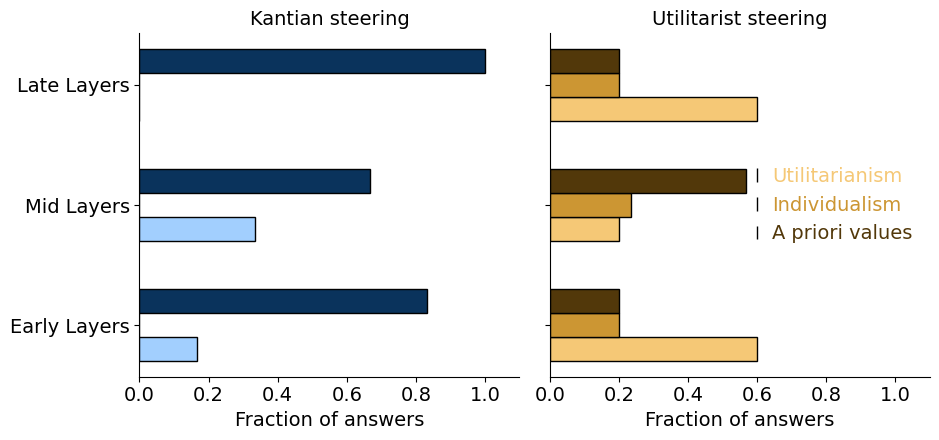

In [623]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Pooling the layers into three groups
def pool_layers(df, layer_groups):
    pooled_df = pd.DataFrame()
    for group_name, layers in layer_groups.items():
        group_data = df[df['Layer'].isin(layers)].groupby(['Category', 'Group']).agg({
            'Fraction': 'mean'
        }).reset_index()
        group_data['Layer_Group'] = group_name
        pooled_df = pd.concat([pooled_df, group_data], ignore_index=True)
    return pooled_df

# Define layer groups
layer_groups = {
    'Early Layers (1-6)': list(range(1, 7)),
    'Intermediate Layers (7-12)': list(range(7, 13)),
    'Late Layers (13-17)': list(range(13, 18))
}

# Pool the data
pooled_data = pool_layers(grouped_counts_layer, layer_groups)

# Set up the subplots
fig, axes = plt.subplots(1, 2, figsize=(9.5,4.5), sharey=True)

# Define the colors for the categories
category_colors = {
    'Utilitarianism': '#a2cffe',
    'Individualism': '#4989cc',
    'A priori values': '#0a335c'
}

category_colors2 = {
    'Utilitarianism': '#f5c876',
    'Individualism': '#cc9633',
    'A priori values': '#52380a'
}

category_colorss = [category_colors, category_colors2]

# Define bar heights and offsets
bar_height = 0.2
width = 0.2
group_positions = {
    'Early Layers': -width,
    'Mid Layers': 0,
    'Late Layers': width
}

# Plot for each steering type
for i, category in enumerate(['Kantian', 'Utilitarist']):
    ax = axes[i]

    for jj, group_name in enumerate(layer_groups.keys()):
        group_data = pooled_data[(pooled_data['Category'] == category) & (pooled_data['Layer_Group'] == group_name)]

        # Plot Utilitarianism bars
        if not group_data[group_data['Group'] == 'Utilitarianism'].empty:
            utilitarianism_width = group_data[group_data['Group'] == 'Utilitarianism']['Fraction'].values[0]
            ax.barh(y=jj-bar_height, width=utilitarianism_width, color=category_colorss[i]['Utilitarianism'], edgecolor='black',
                    height=bar_height, label='Utilitarianism' if group_name == 'Early Layers (1-6)' else "")

        # Plot Egoism bars
        if not group_data[group_data['Group'] == 'Individualism'].empty:
            theory_of_rights_width = group_data[group_data['Group'] == 'Individualism']['Fraction'].values[0]
            ax.barh(y=jj, width=theory_of_rights_width, color=category_colorss[i]['Individualism'], edgecolor='black',
                    height=bar_height, label='Individualism' if group_name == 'Early Layers (1-6)' else "")

        # Plot A priori values bars
        if not group_data[group_data['Group'] == 'A priori values'].empty:
            a_priori_values_width = group_data[group_data['Group'] == 'A priori values']['Fraction'].values[0]
            ax.barh(y=jj+bar_height, width=a_priori_values_width, color=category_colorss[i]['A priori values'], edgecolor='black',
                    height=bar_height, label='A priori values' if group_name == 'Early Layers (1-6)' else "")

    # Configure the subplot
    ax.set_yticks([0,1,2], list(group_positions.keys()))
    ax.set_xlim(0, 1.1)
    ax.set_xticks(np.linspace(0, 1, 6), np.linspace(0, 1, 6).round(1), fontsize=14)
    ax.set_title(category+' steering', fontsize=14)
    ax.set_xlabel('Fraction of answers', fontsize=14)
    ax.set_yticklabels(list(group_positions.keys()), fontsize=14)

axes[1].legend(fontsize=14, title_fontsize=14, frameon=False, handlelength=0, labelcolor='linecolor')
plt.tight_layout()
sns.despine()
plt.savefig('SteeringResults_PooledLayers_21052024.svg', transparent = True)